# ERPs Analysis
In this notebook, we take the MATLAB files containing each subject's trials ERPs average per category. We analyse it to find the differences in hiher and lower peak latency across categories after stimulus onset.

### 1. Load data

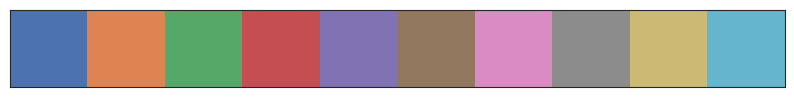

In [29]:
from os.path import dirname, join as pjoin
import scipy.io as sio
import copy
from operator import itemgetter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import argrelextrema
from io import StringIO
import pandas as pd
import pyxdf
#import dataframe_image as dfi
import seaborn as sns
sns.set_style("white")
# choosing the color palette
deep_pal = sns.color_palette('deep')
sns.palplot(deep_pal)

In [4]:
data_path  = "data/erps"
erps_file = pjoin(data_path, "mean_activation_all_8_sub_PO8.mat")
erps_content = sio.loadmat(erps_file)


In [5]:
erps_content

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Feb 23 17:32:45 2023',
 '__version__': '1.0',
 '__globals__': [],
 'erps_body': array([[ 5.91590071,  6.08858109,  6.13964081, ...,  8.31147957,
          7.99672794,  7.60640097],
        [-3.38338923, -3.52877855, -3.38636804, ...,  3.21133637,
          2.89005041,  2.93451309],
        [-0.56786853, -0.22752249, -0.07204956, ...,  7.39566469,
          7.4922514 ,  7.44618845],
        ...,
        [-5.14906216, -5.08445978, -4.95895529, ...,  8.157691  ,
          8.2212677 ,  8.14078999],
        [ 0.3976815 ,  0.24022947, -0.06726853, ...,  9.80734634,
          9.94095135,  9.92884541],
        [ 1.83776033,  1.8231622 ,  1.7332288 , ...,  5.04311323,
          5.05718565,  4.74161291]]),
 'erps_face': array([[ 6.1108408 ,  6.45699406,  6.60611725, ...,  7.62923813,
          7.32023811,  7.14425039],
        [-3.55128717, -3.50814748, -3.50312614, ...,  2.38646984,
          2.3380537 ,  2.36940789],
    

In [6]:
orginal_keys_map = {'body': 'erps_body', 'face': 'erps_face', 'object': 'erps_object', 'subj_time': 'subj_time'}
ch_keys = ["body", "face", "object"]
all_keys = ch_keys.copy()
all_keys.append("subj_time")
df = pd.DataFrame(columns=np.concatenate([all_keys]))

# Extract data for each participant, as many as there are time series
participant_count = len(dict(erps_content)["subj_time"])
for participant in range(participant_count):
    df_participant = pd.DataFrame()
    # Extract all keys into dataframe columns
    for key in all_keys:
        series_array = dict(erps_content)[orginal_keys_map[key]]
        df_participant[key] = pd.Series(series_array[participant])
    df_participant['subject'] = participant

    # Add full participant extraction to final dataframe
    df = pd.concat([df, df_participant], ignore_index=True)

df

,body,face,object,subj_time,subject
0,5.915901,6.110841,5.858163,-199.218750,0.0
1,6.088581,6.456994,6.140627,-197.265625,0.0
2,6.139641,6.606117,6.448425,-195.312500,0.0
3,6.593696,6.790761,6.460158,-193.359375,0.0
4,6.589998,7.117500,6.645327,-191.406250,0.0
...,...,...,...,...,...
2859,5.010485,5.210922,4.485417,490.234375,7.0
2860,5.001881,5.355083,4.451282,492.187500,7.0
2861,5.043113,5.256223,4.632553,494.140625,7.0
2862,5.057186,5.056796,4.908361,496.093750,7.0


In [7]:
# by melting the df this way, I can easy plot the 'variable' columns that contains all categories
df2 = df.melt(id_vars=["subj_time","subject"])
df2

,subj_time,subject,variable,value
0,-199.218750,0.0,body,5.915901
1,-197.265625,0.0,body,6.088581
2,-195.312500,0.0,body,6.139641
3,-193.359375,0.0,body,6.593696
4,-191.406250,0.0,body,6.589998
...,...,...,...,...
8587,490.234375,7.0,object,4.485417
8588,492.187500,7.0,object,4.451282
8589,494.140625,7.0,object,4.632553
8590,496.093750,7.0,object,4.908361


(-199.21875, 498.046875)

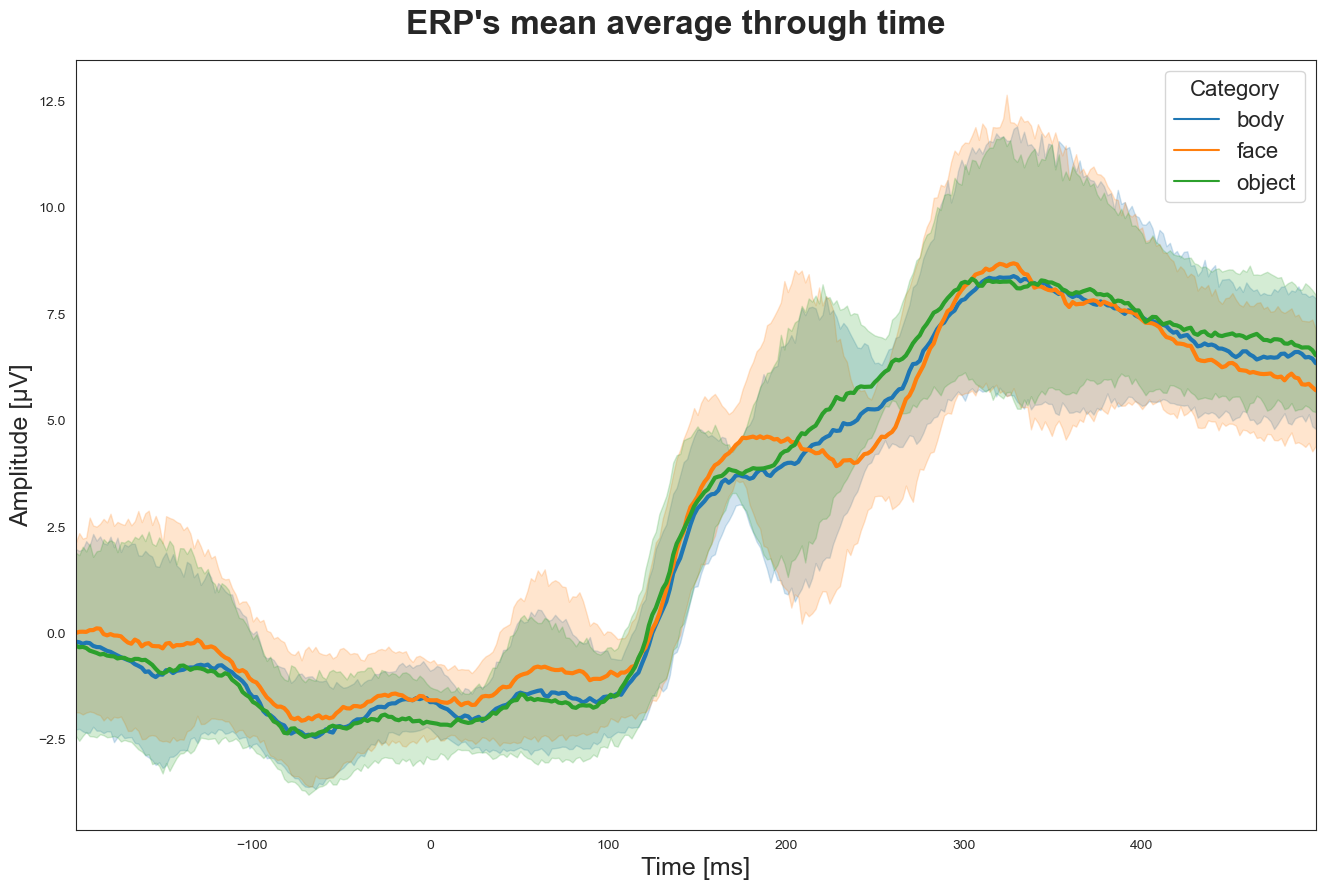

In [8]:
fig, ax = plt.subplots(nrows=1, figsize=(16, 10))
plt.rcParams.update({'font.size': 14})
# time_window = df.loc[df['subject'] == 1, 'sub_time']
# time_window
fig.suptitle("ERP's mean average through time",fontsize=24, y=0.93, fontweight='bold')
sns.lineplot(data= df2, x='subj_time', y='value', hue='variable', linewidth=3, ax=ax)
ax.set_ylabel("Amplitude [\u03BCV]", fontsize=18)
ax.set_xlabel("Time [ms]", fontsize=18)
plt.legend(title='Category',fontsize=16, title_fontsize='16')
ax.set_xlim(df2['subj_time'].min(),df2['subj_time'].max())

### 2. Create time windows to calculate max and min peak

In [9]:
n = 10  # number of points to be checked before and after
rolling_gradient_window = 20
find_gradient_extrema_start_time = 0 # start to look for gradient extrema
find_gradient_extrema_end_time = 200

# Clean up old dataframe before making a copy
if 'df3' in locals():
    del df3
df3 = df

# Calculate local maxima and minima
for key in ch_keys:
    df3[key+'_min'] = df3.iloc[argrelextrema(df3[key].values, np.less_equal, order=n)[0]][key]
    df3[key+'_max'] = df3.iloc[argrelextrema(df3[key].values, np.greater_equal, order=n)[0]][key]

    # Calculate gradients, i.e., slops of the data; hypothesis: first steepest upwards gradient is where the time window for the max / min should be looked for
    df3[key+'_grads'] = np.gradient(df3[key].rolling(rolling_gradient_window, center=True).mean())
    grads_extrema = []

    # Find extrema (min max) per participant
    for participant in range(participant_count):
        df3_part = df3[(df3['subject'] == participant) & # select participant
                       (df3['subj_time'] > find_gradient_extrema_start_time) & # select start time to find gradient extrema
                       (df3['subj_time'] <= find_gradient_extrema_end_time)] # select end time to find graident extrema
        # grads_extrema.append(df3_part[key+"_grads"].idxmin())
        grads_extrema.append(df3_part[key+"_grads"].idxmax())

    # Store all gradient extrema back into the pandas dataframe
    df3[key+'_grads_extrema'] = df3.iloc[np.array(grads_extrema)][key+"_grads"]
    df3[key+'_grads_extrema_key_value'] = df3.loc[df3[key+'_grads_extrema'].notna()][key]

df3

,body,face,object,subj_time,subject,body_min,body_max,body_grads,body_grads_extrema,body_grads_extrema_key_value,face_min,face_max,face_grads,face_grads_extrema,face_grads_extrema_key_value,object_min,object_max,object_grads,object_grads_extrema,object_grads_extrema_key_value
0,5.915901,6.110841,5.858163,-199.218750,0.0,5.915901,NaN,NaN,NaN,NaN,6.110841,NaN,NaN,NaN,NaN,5.858163,NaN,NaN,NaN,NaN
1,6.088581,6.456994,6.140627,-197.265625,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.139641,6.606117,6.448425,-195.312500,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.593696,6.790761,6.460158,-193.359375,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.589998,7.117500,6.645327,-191.406250,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2859,5.010485,5.210922,4.485417,490.234375,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2860,5.001881,5.355083,4.451282,492.187500,7.0,NaN,NaN,NaN,NaN,NaN,NaN,5.355083,NaN,NaN,NaN,4.451282,NaN,NaN,NaN,NaN
2861,5.043113,5.256223,4.632553,494.140625,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2862,5.057186,5.056796,4.908361,496.093750,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


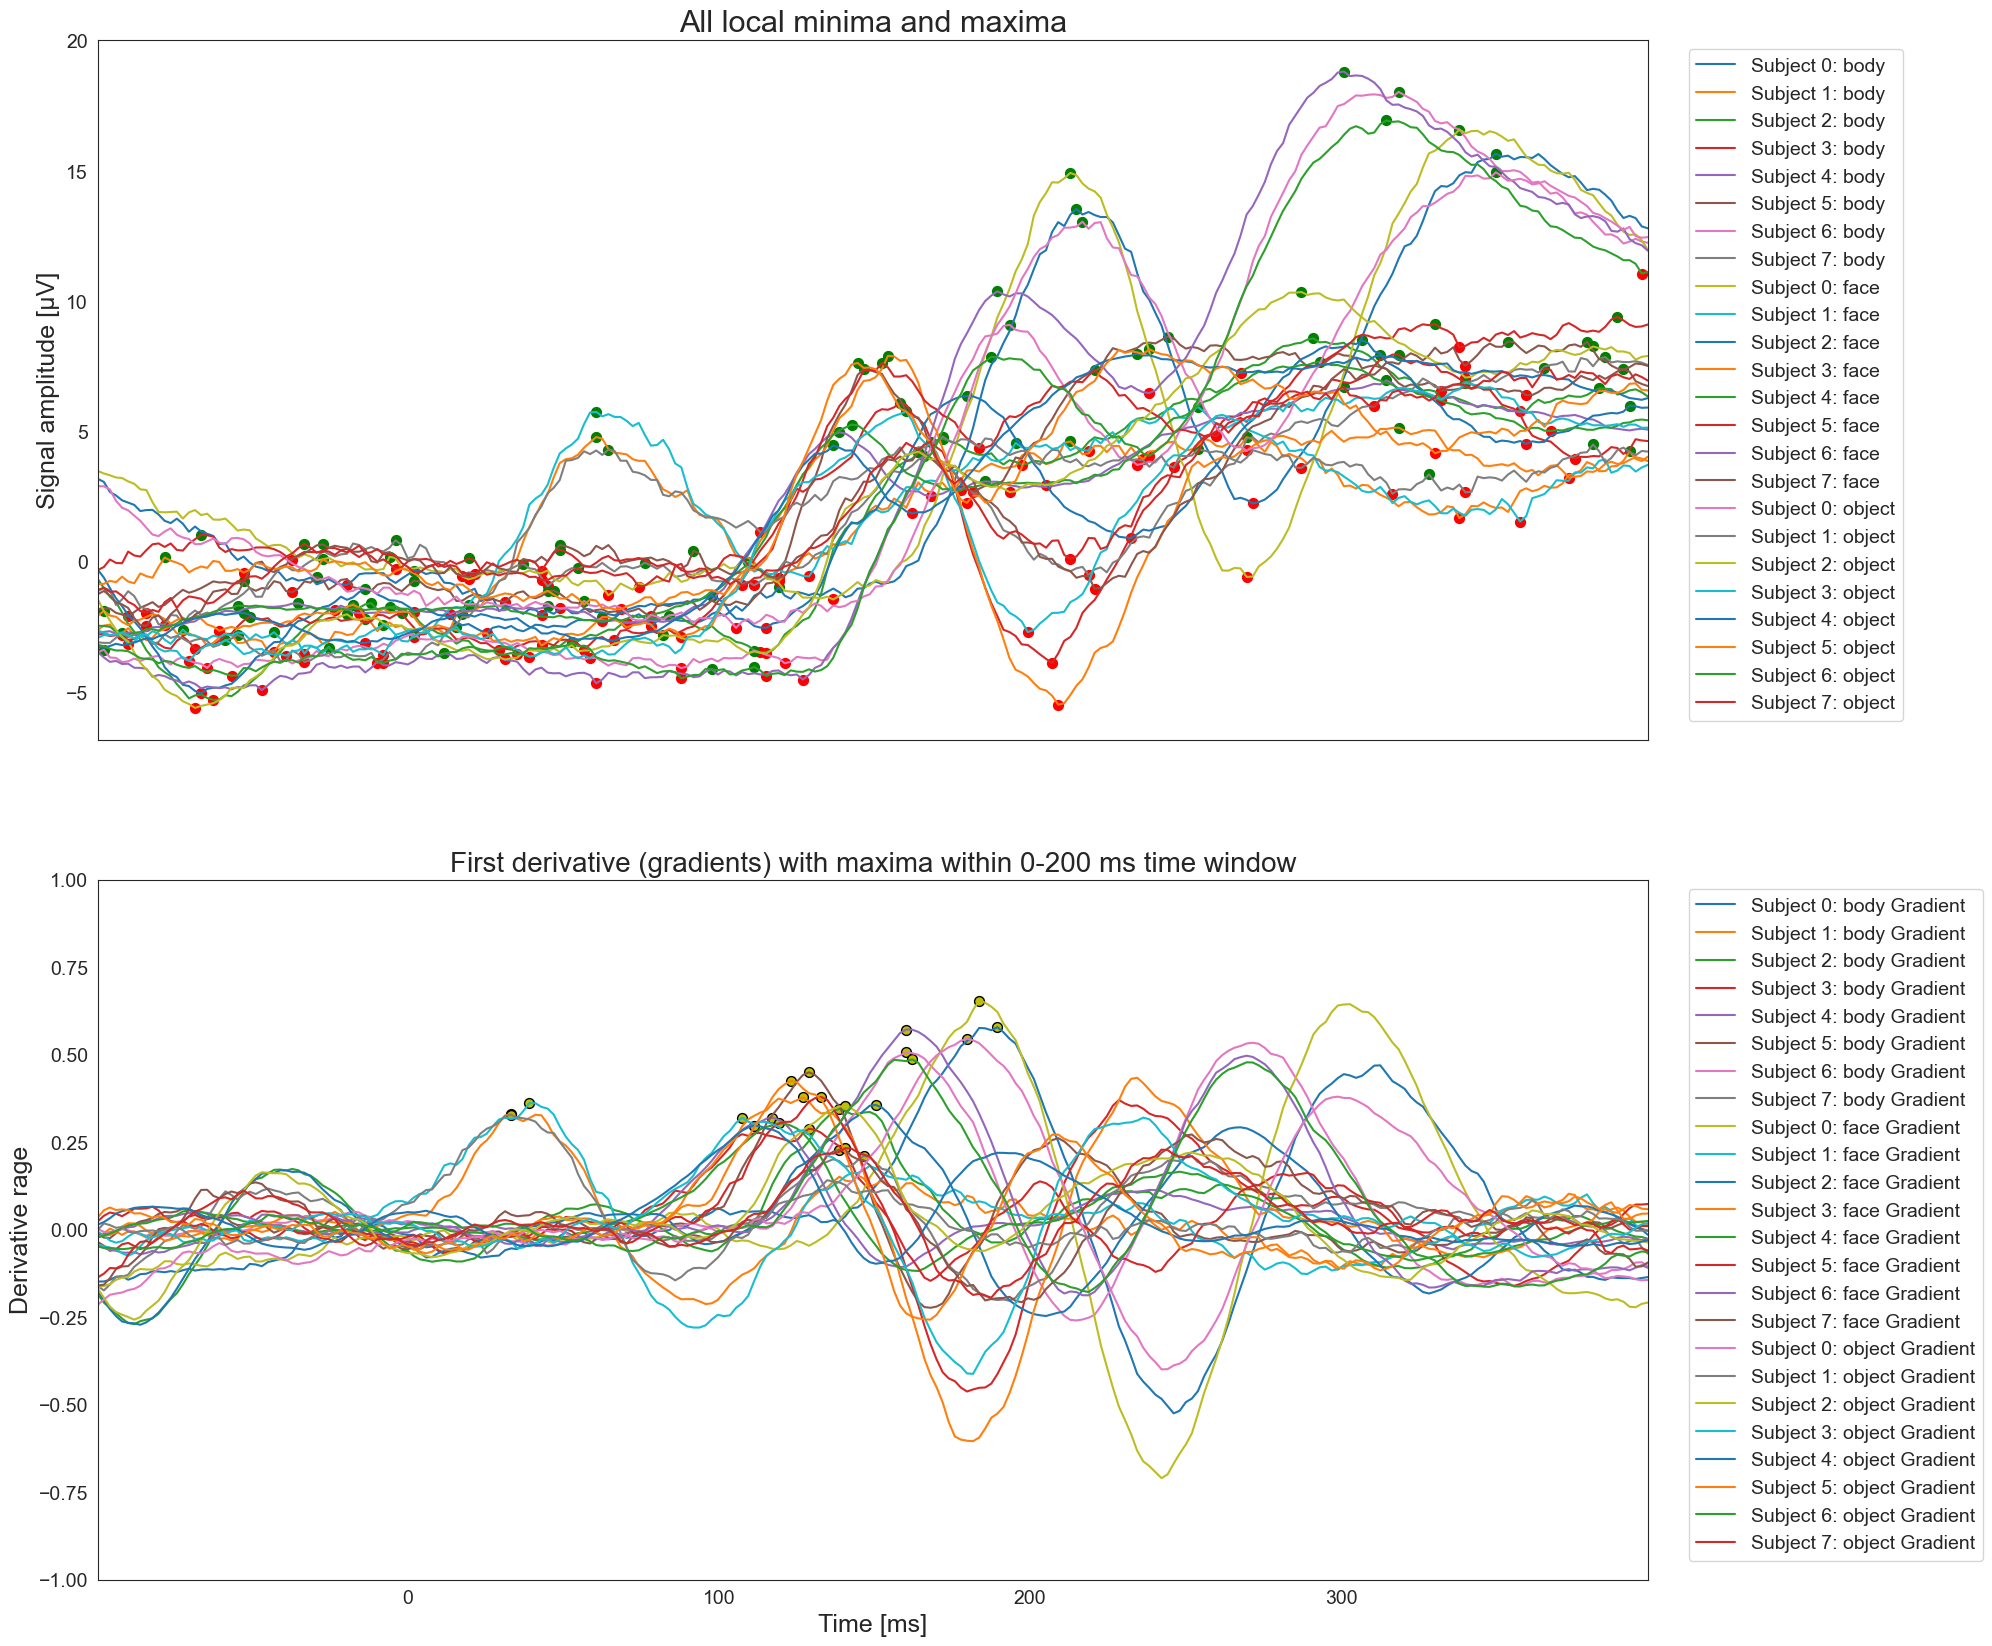

In [10]:
# Plot results
global_time_window_start = -100
global_time_window_end = 400

fig, ax = plt.subplots(figsize=(20,20), ncols=1, nrows=2, sharex=True)

for key in ch_keys:
    for participant in range(participant_count):
        df4 = df3[df3['subject'] == participant] # select participant
        df4 = df4[(df4['subj_time'] > global_time_window_start) & (df4['subj_time'] < global_time_window_end)] # select time window
        ax[0].scatter(df4.subj_time, df4[key+'_min'], c='r', s=50)
        ax[0].scatter(df4.subj_time, df4[key+'_max'], c='g',s=50)
        line, = ax[0].plot(df4.subj_time, df4[key])
        line.set_label(f"Subject {participant}: {key}")
        ax[0].set_title("All local minima and maxima", fontsize=22)
        ax[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        ax[0].set_xlim(df4['subj_time'].min(),df4['subj_time'].max())
        ax[0].set_ylabel("Signal amplitude [\u03BCV]", fontsize=18)

        # # Also print gradients and their extrema
        ax[1].scatter(df4.subj_time, df4[key+'_grads_extrema'], c='y',s=50,edgecolors='black')
        line, = ax[1].plot(df4.subj_time, df4[key+'_grads'])
        line.set_label(f"Subject {participant}: {key} Gradient")
        ax[1].set_xlim(df4['subj_time'].min(),df4['subj_time'].max())
        # find the point in time when slope is the steepest of smoothened data (n=20)
        ax[1].set_title("First derivative (gradients) with maxima within 0-200 ms time window", fontsize=20)
        ax[1].set_ylim(-1,1)
        ax[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        ax[1].set_ylabel("Derivative rage", fontsize=18)
        ax[1].set_xlabel("Time [ms]", fontsize=18)

plt.show()

### 3. Find individual peaks
Find maximum positive and negative peaks per subject

Subject 0, key body has minimum 2.2399916648864746 and maximum 13.544217109680176, difference is 11.304225444793701
Subject 0, key face has minimum -0.5760124325752258 and maximum 14.922928810119629, difference is 15.498941242694855
Subject 0, key object has minimum 4.273242473602295 and maximum 13.051939964294434, difference is 8.778697490692139


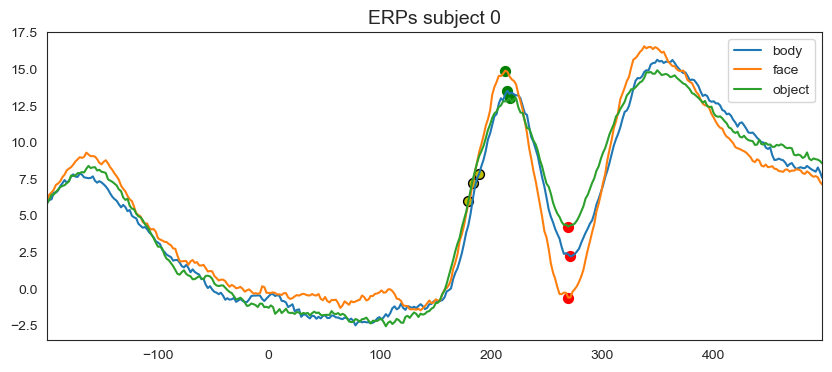

Subject 1, key body has minimum -0.7455092668533325 and maximum 4.79033088684082, difference is 5.535840153694153
Subject 1, key face has minimum -0.5618327260017395 and maximum 5.753466606140137, difference is 6.315299332141876
Subject 1, key object has minimum 1.1412217617034912 and maximum 4.3072123527526855, difference is 3.1659905910491943


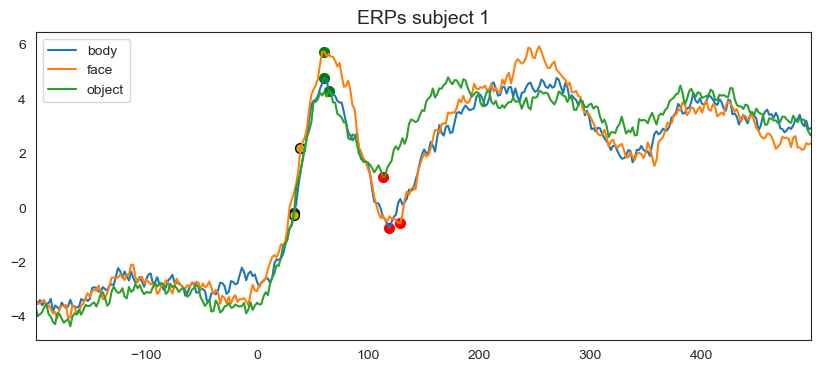

Subject 2, key body has minimum 3.7351179122924805 and maximum 4.731099605560303, difference is 0.9959816932678223
Subject 2, key face has minimum 0.9126566648483276 and maximum 6.3574323654174805, difference is 5.444775700569153
Subject 2, key object has minimum 2.679304838180542 and maximum 4.229971885681152, difference is 1.5506670475006104


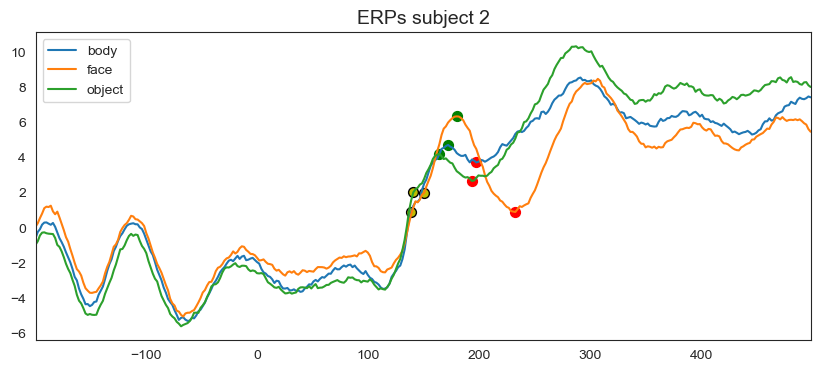

Subject 3, key body has minimum -3.881314516067505 and maximum 6.104855537414551, difference is 9.986170053482056
Subject 3, key face has minimum -5.477518558502197 and maximum 7.905889511108398, difference is 13.383408069610596
Subject 3, key object has minimum -2.695131301879883 and maximum 5.770120143890381, difference is 8.465251445770264


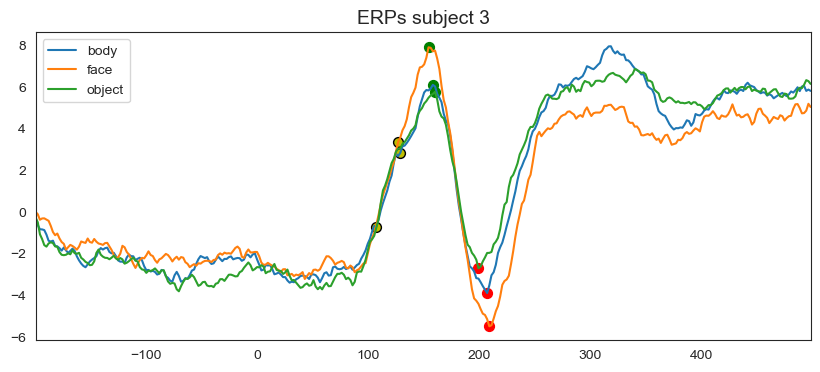

Subject 4, key body has minimum 2.5199246406555176 and maximum 4.969473838806152, difference is 2.4495491981506348
Subject 4, key face has minimum 2.738710641860962 and maximum 5.268340587615967, difference is 2.529629945755005
Subject 4, key object has minimum 1.8611074686050415 and maximum 4.465773105621338, difference is 2.6046656370162964


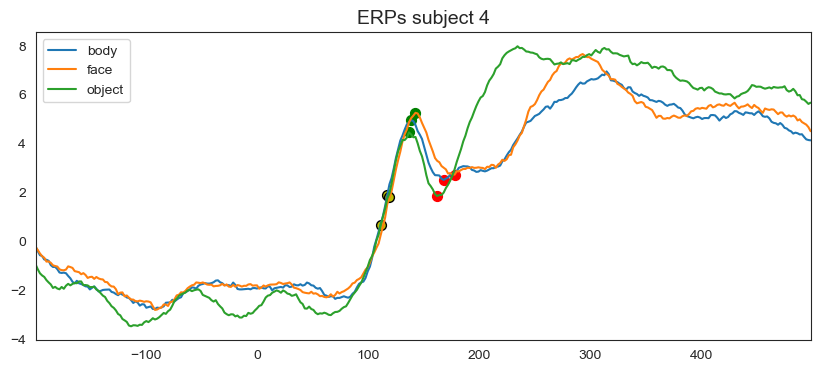

Subject 5, key body has minimum 2.687896251678467 and maximum 7.39567756652832, difference is 4.7077813148498535
Subject 5, key face has minimum 4.36458683013916 and maximum 7.625518798828125, difference is 3.260931968688965
Subject 5, key object has minimum 2.267371416091919 and maximum 7.632042407989502, difference is 5.364670991897583


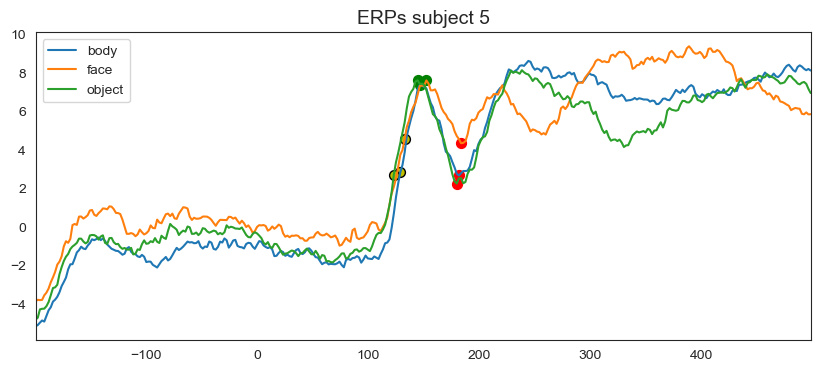

Subject 6, key body has minimum 3.719270944595337 and maximum 9.096206665039062, difference is 5.376935720443726
Subject 6, key face has minimum 6.47817325592041 and maximum 10.379767417907715, difference is 3.9015941619873047
Subject 6, key object has minimum 4.071857452392578 and maximum 7.867554187774658, difference is 3.79569673538208


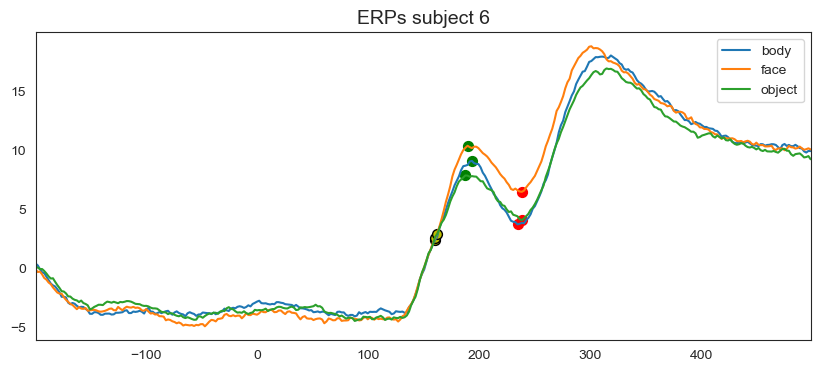

Subject 7, key body has minimum -0.5057152509689331 and maximum 4.0622687339782715, difference is 4.567983984947205
Subject 7, key face has minimum -1.0317906141281128 and maximum 4.2238006591796875, difference is 5.2555912733078
Subject 7, key object has minimum 0.11607088893651962 and maximum 4.608160495758057, difference is 4.492089606821537


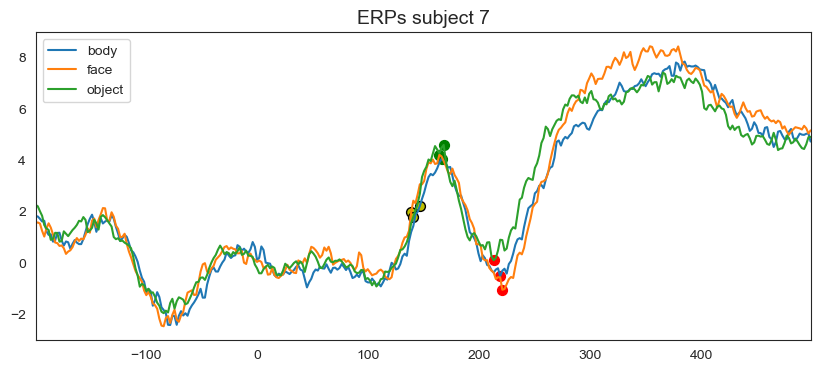

,body,face,object,subj_time,subject,body_min,body_max,body_grads,body_grads_extrema,body_grads_extrema_key_value,face_min,face_max,face_grads,face_grads_extrema,face_grads_extrema_key_value,object_min,object_max,object_grads,object_grads_extrema,object_grads_extrema_key_value
0,5.915901,6.110841,5.858163,-311.295573,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.088581,6.456994,6.140627,-309.342448,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.139641,6.606117,6.448425,-307.389323,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.593696,6.790761,6.460158,-305.436198,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.589998,7.117500,6.645327,-303.483073,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2859,5.010485,5.210922,4.485417,421.126302,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2860,5.001881,5.355083,4.451282,423.079427,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2861,5.043113,5.256223,4.632553,425.032552,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2862,5.057186,5.056796,4.908361,426.985677,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,subject,key,min,max,diff
0,0,body,2.239992,13.544217,11.304225
1,0,face,-0.576012,14.922929,15.498941
2,0,object,4.273242,13.051940,8.778697
3,1,body,-0.745509,4.790331,5.535840
4,1,face,-0.561833,5.753467,6.315299
5,1,object,1.141222,4.307212,3.165991
6,2,body,3.735118,4.731100,0.995982
7,2,face,0.912657,6.357432,5.444776
8,2,object,2.679305,4.229972,1.550667
9,3,body,-3.881315,6.104856,9.986170


,diff
key,
body,5.615558
face,6.948771
object,4.777216


In [11]:
# Min / Max / Diff output dataframe
df_min_max = pd.DataFrame(columns=['subject', 'key', 'min', 'max', 'diff'])

# Cleaned output dataframe
if 'df_cleaned' in locals():
    del df_cleaned
df_cleaned = pd.DataFrame(columns=df3.columns)

# Dataframe to collect all signal onsets so that a time realignment at the end can be done
onset_all = pd.DataFrame()

# Store all maximum values, so we can align chart visually to have the mean maximum be at t = 100 ms
maxs_time = pd.Series(dtype='float64')

# fig, ax = plt.subplots(figsize=(20,20), ncols=2, nrows=round(participant_count/2), sharex=True)
plt.rcParams.update({'font.size': 10})
for participant in range(participant_count):
    # Set up participant visualization
    fig, ax = plt.subplots(figsize=(10,4))
    # Initiate participant cleaned dataframe
    df_participant_cleaned = df3[df3['subject'] == participant][['subject', 'subj_time']]

    ## Step 1: find the mean onset time for given participant (i.e., when gradient is steepest)
    df4 = df3[df3['subject'] == participant]
    df4.reset_index(inplace=True)

    # Get all participant's onset time stamp
    onset = pd.DataFrame()
    for key in ch_keys:
        onset = pd.concat([onset, df4.iloc[np.array([df4[key + '_grads_extrema'].idxmax()])]['subj_time']], ignore_index=True)

    onset_time_mean = onset.mean().loc[0] # use as the average subj_time time shift for this participant
    onset_time_min = onset.min().loc[0] # use as selection start time for cleaned data set and participant visualization
    onset_time_max = onset.max().loc[0] # use as selection end time for data cleaning and participant visualization (for onset points only)

    for key in ch_keys:
        ## Step 2: find the first min and max post the mean onset
        df4 = df3[(df3['subject'] == participant) &
                  (df3['subj_time'] >= onset_time_mean)]
        df4.reset_index(inplace=True)

        # Get participant first minima and maxima post the mean onset time
        max = df4.iloc[df4[key + '_max'].first_valid_index()][key + '_max']
        min = df4.iloc[df4[key + '_min'].first_valid_index()][key + '_min']

        # Store all participants maximum's time stamps
        maxs_time = pd.concat([maxs_time, pd.Series([df4.iloc[np.array([df4[key + '_max'].first_valid_index()])]['subj_time'].iloc[0]])])

        # Set the end time of the local window, so we can use this to generate a clean, aligned dataset
        local_time_window_end = df4.iloc[np.array([df4[key + '_min'].first_valid_index()])]['subj_time'].iloc[0]

        ## Step 3: Add the min + max and diff to the resulting data frame
        print(f"Subject {participant}, key {key} has minimum {min} and maximum {max}, difference is {max-min}")
        d = {'subject': [participant], 'key': [key], 'min': [min], 'max': [max], 'diff': [max-min]}
        df_min_max = pd.concat([df_min_max, pd.DataFrame.from_dict(d)], ignore_index=True)

        ## Step 4: Assemble a clean dataframe
        # Part 1: add corrected time stamp, key and key gradient data
        df4 = df3[(df3['subject'] == participant)]
        df_participant_cleaned['subj_time'] = df4['subj_time'] - onset_time_mean
        df_participant_cleaned[key] = df4[key]
        df_participant_cleaned[key + '_grads'] = df4[key + '_grads']

        # Part 2: add key's min and max data only between onset time and local time window end
        df5 = df4[(df4['subj_time'] >= onset_time_min) &
                  (df4['subj_time'] <= local_time_window_end)]
        df_participant_cleaned[key + '_min'] = df5[key + '_min']
        df_participant_cleaned[key + '_max'] = df5[key + '_max']

        # Part 3: add key's onset gradient and value at that point (select only from within onset min to max range)
        df6 = df5[df5['subj_time'] <= onset_time_max]
        df_participant_cleaned[key + '_grads_extrema'] = df6[key + '_grads_extrema']
        df_participant_cleaned[key + '_grads_extrema_key_value'] = df6[key + '_grads_extrema_key_value']

        ## Step 5: Plot each participant data
        df4_points_min_max = df4[(df4['subj_time'] >= onset_time_min) & (df4['subj_time'] <= local_time_window_end)] # select time window
        ax.scatter(df4_points_min_max.subj_time, df4_points_min_max[key+'_min'], c='r',s=50)
        ax.scatter(df4_points_min_max.subj_time, df4_points_min_max[key+'_max'], c='g',s=50)
        df4_points_onset = df4[(df4['subj_time'] >= onset_time_min) & (df4['subj_time'] <= onset_time_max)] # select time window
        ax.scatter(df4_points_onset.subj_time, df4_points_onset[key+'_grads_extrema_key_value'], c='y',s=50,edgecolors='black')
        line, = plt.plot(df4.subj_time, df4[key])
        line.set_label(f"{key}")
        ax.set_title(f"ERPs subject {participant}", fontsize=14)
        ax.set_xlim(df4['subj_time'].min(),df4['subj_time'].max())
        plt.legend()

    # Assemble cleaned data frame
    df_cleaned = pd.concat([df_cleaned, df_participant_cleaned], ignore_index=True)

    # Collect participant's onset points
    onset_all = pd.concat([onset_all, onset], ignore_index=True)

    # Visualize participant
    # plt.legend()
    plt.show()


# Method 1: Add mean onset back to regain time series alignment for cleaned data frame
#df_cleaned['subj_time'] = df_cleaned['subj_time'].add(onset_all.mean().loc[0])

# Method 2: Add mean of maximums - 100ms back to align time series for cleaned data frame such that maximums are at t = 100ms
df_cleaned['subj_time'] = df_cleaned['subj_time'].add(onset_all.mean().loc[0] - maxs_time.mean() + 100)

# Calculate start time of fully overlapping participant data
cleaned_start_time = df_cleaned.groupby(['subject']).agg({'subj_time': 'min'}).max().iloc[0]

# Align time stamps into buckets
bucket_time = df_cleaned[df_cleaned['subj_time'] >= cleaned_start_time][['subject', 'subj_time']].sort_values(by=['subj_time', 'subject']).iloc[0:participant_count].sort_values(by=['subject'])
bucket_time['subj_time'] = bucket_time['subj_time'].sub(bucket_time['subj_time'].mean())
df_cleaned['subj_time'] = df_cleaned.apply(lambda x: round(x['subj_time'] - bucket_time[bucket_time['subject'] == x['subject']]['subj_time'].min(), 6), axis = 1)

# Calculate new end time of fully overlapping participant data
cleaned_end_time = df_cleaned.groupby(['subject']).agg({'subj_time': 'max'}).min().iloc[0]

display(df_cleaned, df_min_max, df_min_max.groupby(['key']).agg({'diff': 'mean'}))

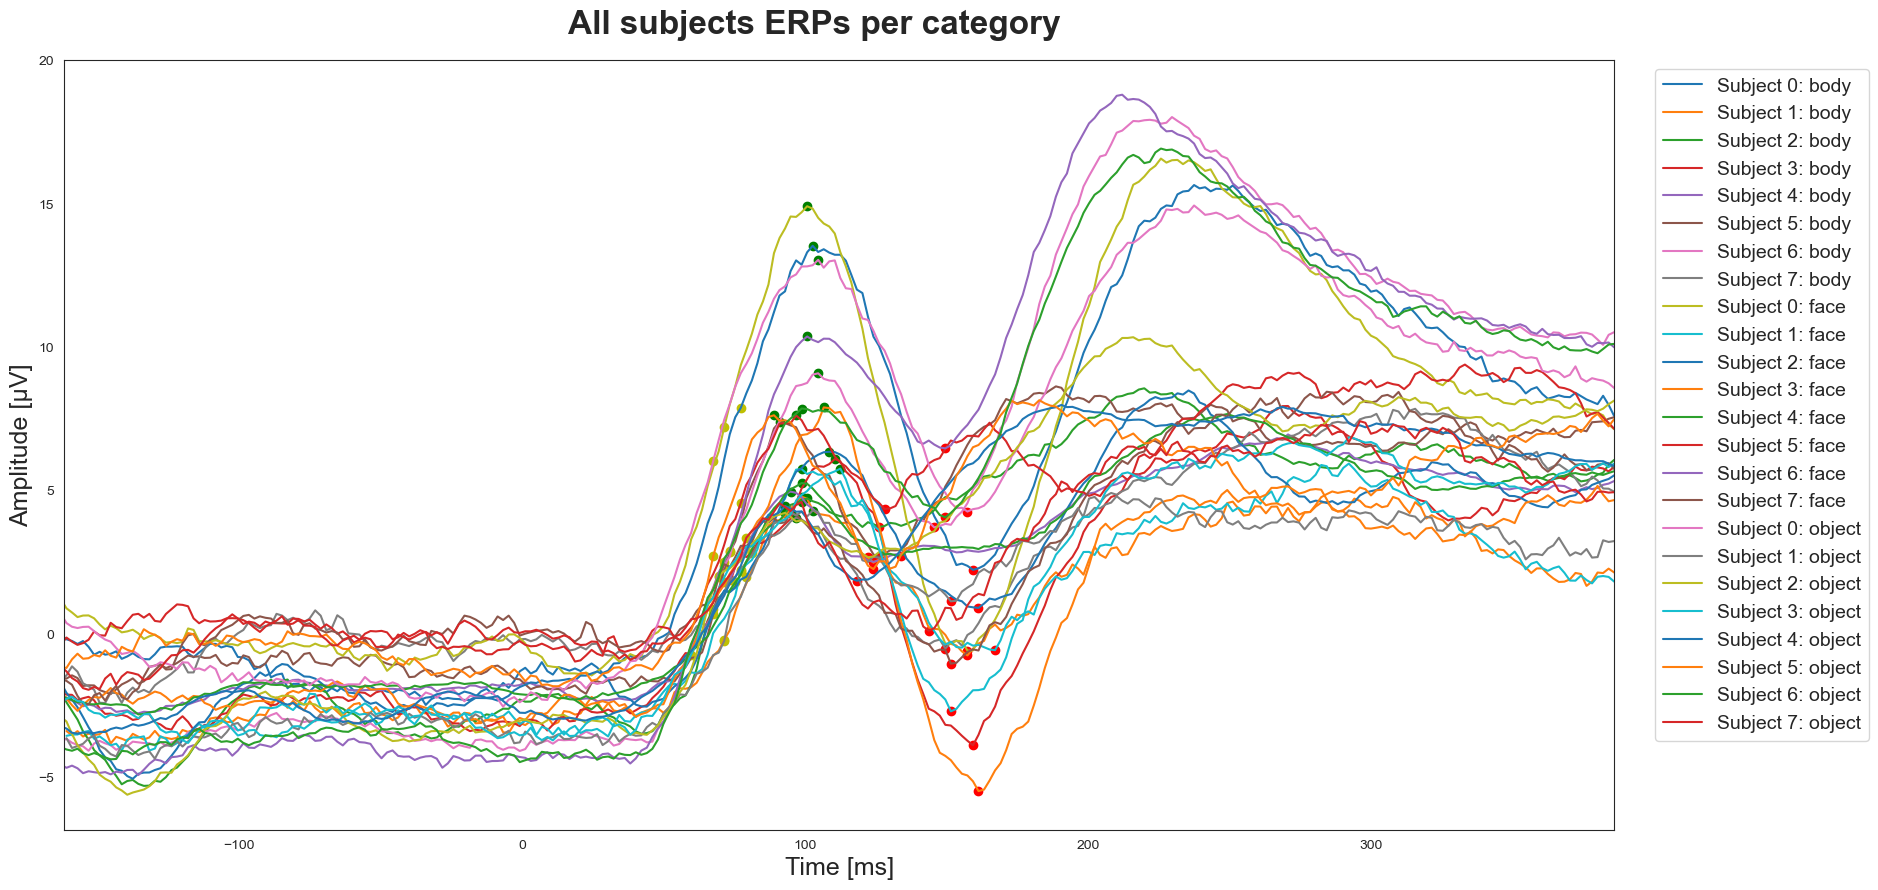

In [12]:
# Plot results
# plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(20,10))
fig.suptitle("All subjects ERPs per category",fontsize=24, y=0.93, fontweight='bold')
plt.rcParams.update({'font.size': 14})
for key in ch_keys:
    for participant in range(participant_count):
        df4 = df_cleaned[df_cleaned['subject'] == participant] # select participant
        plt.scatter(df4.subj_time, df4[key+'_min'], c='r')
        plt.scatter(df4.subj_time, df4[key+'_max'], c='g')
        plt.scatter(df4.subj_time, df4[key+'_grads_extrema_key_value'], c='y')
        line, = plt.plot(df4.subj_time, df4[key])
        line.set_label(f"Subject {participant}: {key}")

        # ax.set_ylim(-1,1)
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        ax.set_ylabel("Amplitude [\u03BCV]", fontsize=18)
        ax.set_xlabel("Time [ms]", fontsize=18)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xlim([cleaned_start_time, cleaned_end_time])
plt.show()

In [13]:
df_cleaned

,body,face,object,subj_time,subject,body_min,body_max,body_grads,body_grads_extrema,body_grads_extrema_key_value,face_min,face_max,face_grads,face_grads_extrema,face_grads_extrema_key_value,object_min,object_max,object_grads,object_grads_extrema,object_grads_extrema_key_value
0,5.915901,6.110841,5.858163,-311.295573,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.088581,6.456994,6.140627,-309.342448,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.139641,6.606117,6.448425,-307.389323,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.593696,6.790761,6.460158,-305.436198,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.589998,7.117500,6.645327,-303.483073,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2859,5.010485,5.210922,4.485417,421.126302,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2860,5.001881,5.355083,4.451282,423.079427,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2861,5.043113,5.256223,4.632553,425.032552,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2862,5.057186,5.056796,4.908361,426.985677,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_cleaned = df_cleaned[["body", "face", "object", "subj_time", "subject"]]#.melt(id_vars=["subj_time","subject"])
mask = (df_cleaned['subj_time'] >= cleaned_start_time) & (df_cleaned['subj_time'] <= cleaned_end_time)
df_masked_erps = df_cleaned.loc[mask]
df_masked4 = df_masked_erps.melt(id_vars=["subj_time","subject"])
df_masked4

,subj_time,subject,variable,value
0,-160.904948,0.0,body,-0.182969
1,-158.951823,0.0,body,-0.240746
2,-156.998698,0.0,body,-0.344782
3,-155.045573,0.0,body,-0.243672
4,-153.092448,0.0,body,-0.445178
...,...,...,...,...
6739,378.157552,7.0,object,4.704927
6740,380.110677,7.0,object,4.960660
6741,382.063802,7.0,object,4.969170
6742,384.016927,7.0,object,4.934233


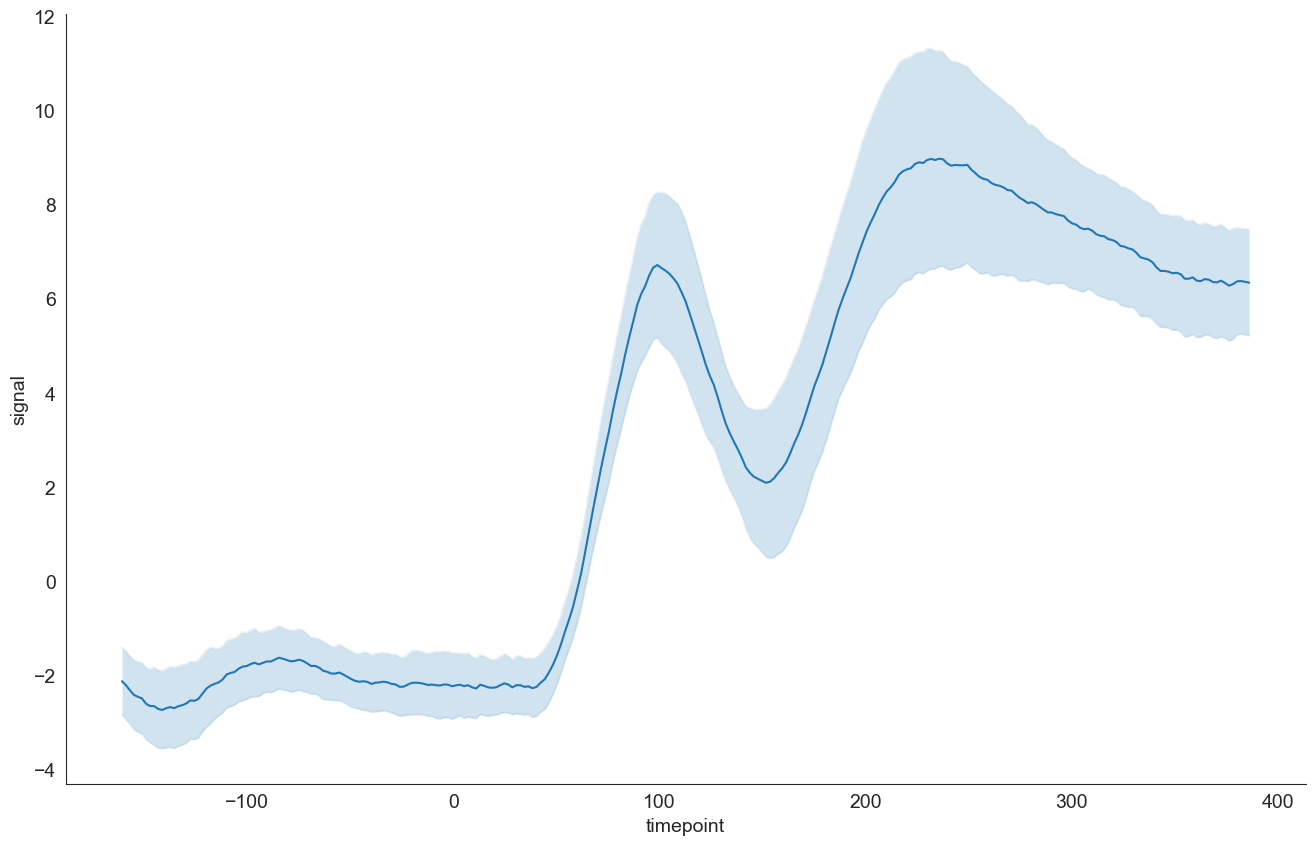

In [15]:
# Define variables to plot
y_mean = df_masked4.groupby(['subj_time']).mean()['value']
x = y_mean.index
# Compute upper and lower bounds using chosen uncertainty measure: here
# it is a fraction of the standard deviation of measurements at each
# time point based on the unbiased sample variance
y_std = df_masked4.groupby(['subj_time']).std()['value']
error = 0.5*y_std
lower = y_mean - error
upper = y_mean + error
# Draw plot with error band and extra formatting to match seaborn style
fig, ax = plt.subplots(nrows=1, figsize=(16, 10))
plt.rcParams.update({'font.size': 14})
ax.plot(x, y_mean, label='signal mean')
ax.plot(x, lower, color='tab:blue', alpha=0.1)
ax.plot(x, upper, color='tab:blue', alpha=0.1)
ax.fill_between(x, lower, upper, alpha=0.2)
ax.set_xlabel('timepoint')
ax.set_ylabel('signal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [293]:
# original from previous analysis
# colors = dict(object=deep_pal[4], face=deep_pal[0], body=deep_pal[1])
# colors = dict(object=deep_pal[0], face=deep_pal[1], body=deep_pal[3])
colors = dict(object="#046378", face="#D0465A", body="#C99756")

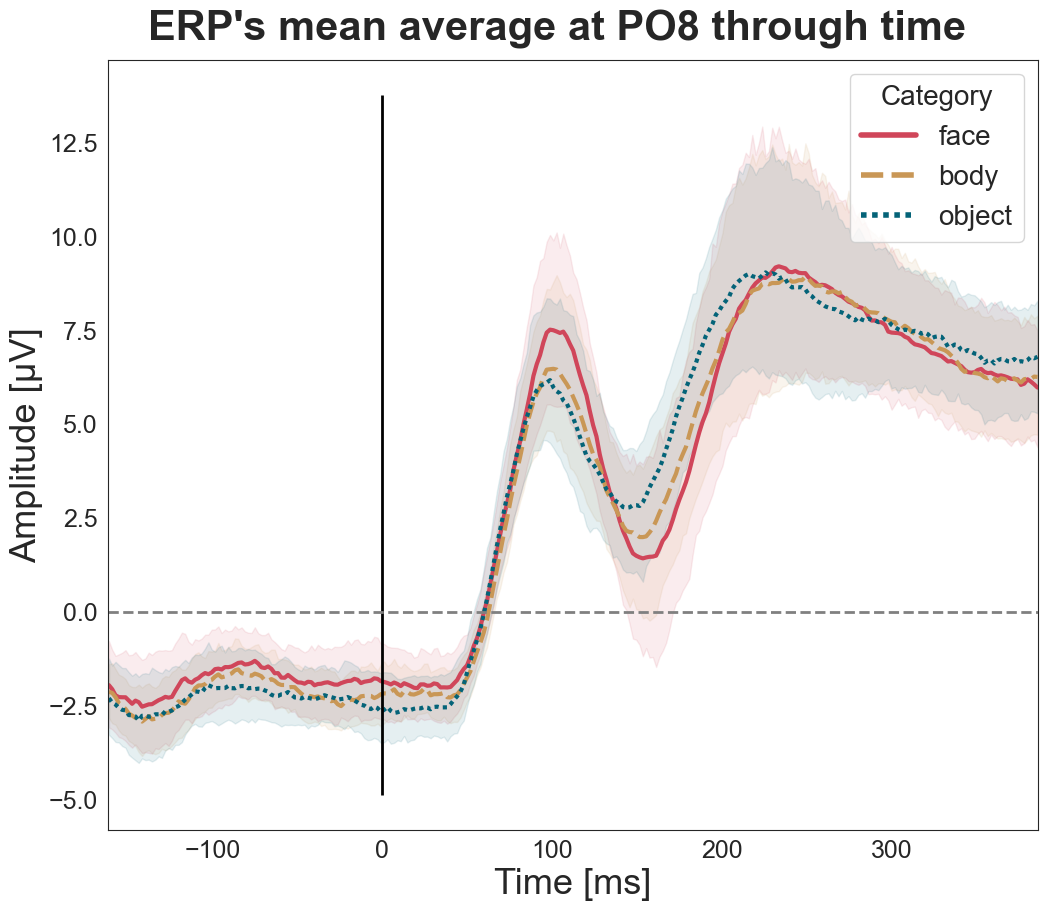

In [321]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 10))
plt.rcParams.update({'font.size': 22})
# time_window = df.loc[df['subject'] == 1, 'sub_time']
# time_window
fig.suptitle("ERP's mean average at PO8 through time",fontsize=30, y=0.93, fontweight='bold')
g = sns.lineplot(data= df_masked4, x='subj_time', y='value', hue='variable', linewidth=3,
                 style='variable',
                 style_order=['face','body','object'],
                 hue_order=['face','body','object'],
                 palette=colors,err_kws={"alpha": .1},ax=ax)
# g = sns.relplot(data=df_masked4, x="subj_time", y="value",
#                 hue="variable", style="variable", kind="line")
ax.set_ylabel("Amplitude [\u03BCV]", fontsize=26)
ax.set_xlabel("Time [ms]", fontsize=26)
ax.set_xlim(cleaned_start_time, cleaned_end_time)

# # obtain the handles and labels from the figure
handles, labels = ax.get_legend_handles_labels()
# copy the handles
handles = [copy.copy(ha) for ha in handles ]
# set the linewidths to the copies
[ha.set_linewidth(4) for ha in handles ]
# put the copies into the legend
leg = plt.legend(title='Category',fontsize=20, title_fontsize='20', handles=handles, labels=labels)
# y min and max
ymin, ymax = g.get_ylim()
xmin, xmax = g.get_xlim()
# vertical lines
g.vlines(x=0, ymin=ymin, ymax=ymax, colors=['black'], lw=2)
g.hlines(y=0, xmin=xmin, xmax=xmax, colors=['gray'], ls='--', lw=2)
format='pdf'
# plt.savefig(data_path + "/images/"+"NEWER_erps_mean_average_through_time"+"."+format, format=format, dpi=1200)

In [322]:
# df_cleaned[df_cleaned['erps_face_min'].notnull()]

In [323]:
df_min_max

,subject,key,min,max,diff
0,0,body,2.239992,13.544217,11.304225
1,0,face,-0.576012,14.922929,15.498941
2,0,object,4.273242,13.051940,8.778697
3,1,body,-0.745509,4.790331,5.535840
4,1,face,-0.561833,5.753467,6.315299
5,1,object,1.141222,4.307212,3.165991
6,2,body,3.735118,4.731100,0.995982
7,2,face,0.912657,6.357432,5.444776
8,2,object,2.679305,4.229972,1.550667
9,3,body,-3.881315,6.104856,9.986170


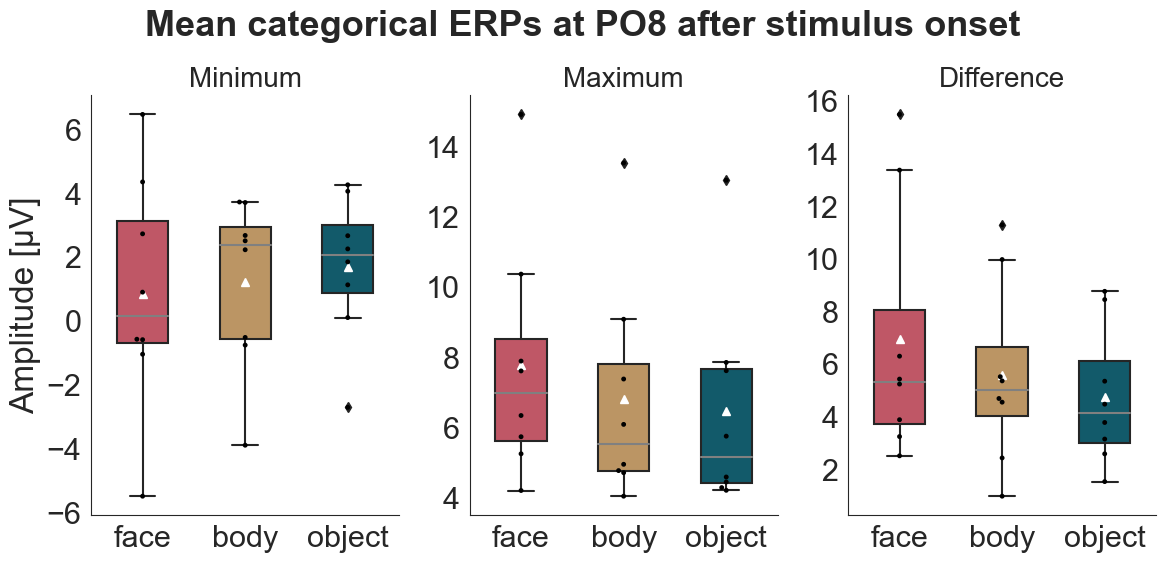

In [324]:
fig, ax = plt.subplots(figsize=(12,6), ncols=3, nrows=1)
plt.rcParams.update({'font.size': 18})
fig.suptitle("Mean categorical ERPs at PO8 after stimulus onset",fontsize=26, y=0.95, fontweight='bold')

# MINIMUM
sns.boxplot(data=df_min_max, x= 'key',y='min',order=['face','body','object'], showmeans=True, palette=colors, width=0.5,
            meanprops={"marker":"^",
                       "markerfacecolor":"white",
                       "markeredgecolor":"white",
                      "markersize":"6"},
            medianprops={"color": "gray"}, ax=ax[0])
sns.swarmplot(data=df_min_max, x= 'key',y='min', order=['face','body','object'],palette={'black', 'black', 'black'}, size=3.5, ax=ax[0])
ax[0].set_title("Minimum", fontsize=20)
ax[0].set_ylabel("Amplitude [\u03BCV]", fontsize=24)
ax[0].set_xlabel(None, fontsize=18)

# MAXIMUM
sns.boxplot(data=df_min_max, x= 'key',y='max',order=['face','body','object'], showmeans=True,palette=colors,width=0.5,
            meanprops={"marker":"^",
                       "markerfacecolor":"white",
                       "markeredgecolor":"white",
                      "markersize":"6"},
            medianprops={"color": "gray"}, ax=ax[1])
sns.swarmplot(data=df_min_max, x= 'key',y='max', order=['face','body','object'],palette={'black', 'black', 'black'}, size=3.5, ax=ax[1])
ax[1].set_title("Maximum", fontsize=20)
ax[1].set_ylabel(None, fontsize=18)
ax[1].set_xlabel(None, fontsize=18)

# DIFFERENCE in amplitude
sns.boxplot(data=df_min_max, x= 'key',y='diff',order=['face','body','object'], showmeans=True,palette=colors,width=0.5,
            meanprops={"marker":"^",
                       "markerfacecolor":"white",
                       "markeredgecolor":"white",
                      "markersize":"6"},
            medianprops={"color": "gray"}, ax=ax[2])
sns.swarmplot(data=df_min_max, x= 'key',y='diff', order=['face','body','object'],palette={'black', 'black', 'black'}, size=3.5, ax=ax[2])
ax[2].set_title("Difference", fontsize=20)
ax[2].set_ylabel(None, fontsize=18)
ax[2].set_xlabel(None, fontsize=18)
sns.despine(top=True)
plt.tight_layout()
# plt.savefig(data_path + "/images/"+"NEWER_erps_activations_differences"+"."+format, format=format, dpi=1200)

In [201]:
df_means2 = df_min_max.melt(id_vars=["subject","key"])
df_means2

,subject,key,variable,value
0,0,body,min,2.239992
1,0,face,min,-0.576012
2,0,object,min,4.273242
3,1,body,min,-0.745509
4,1,face,min,-0.561833
...,...,...,...,...
67,6,face,diff,3.901594
68,6,object,diff,3.795697
69,7,body,diff,4.567984
70,7,face,diff,5.255591


(-10.0, 18.0)

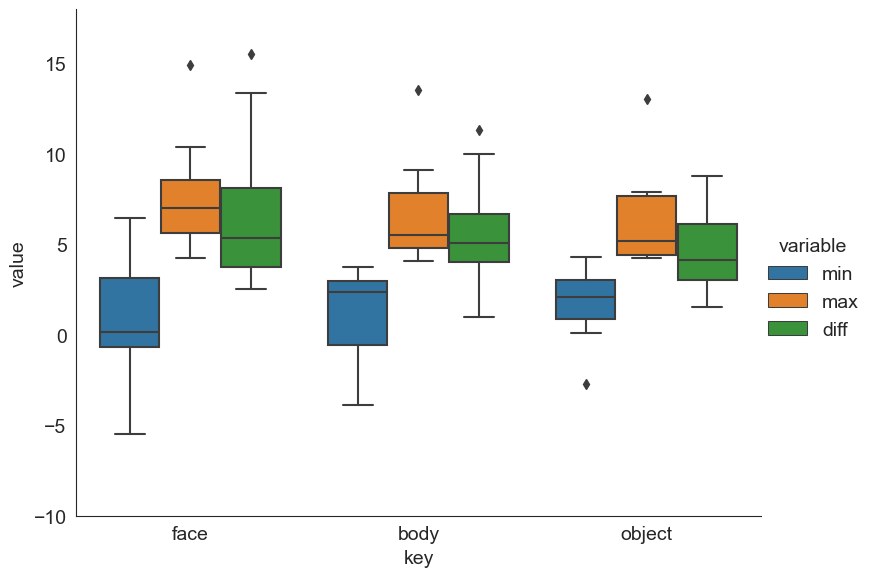

In [420]:
sns.catplot(x='key', y='value',
                 hue="variable",
                data=df_means2, kind="box",order=['face','body','object'],
            height=6, aspect=1.3)
plt.ylim(-10, 18)

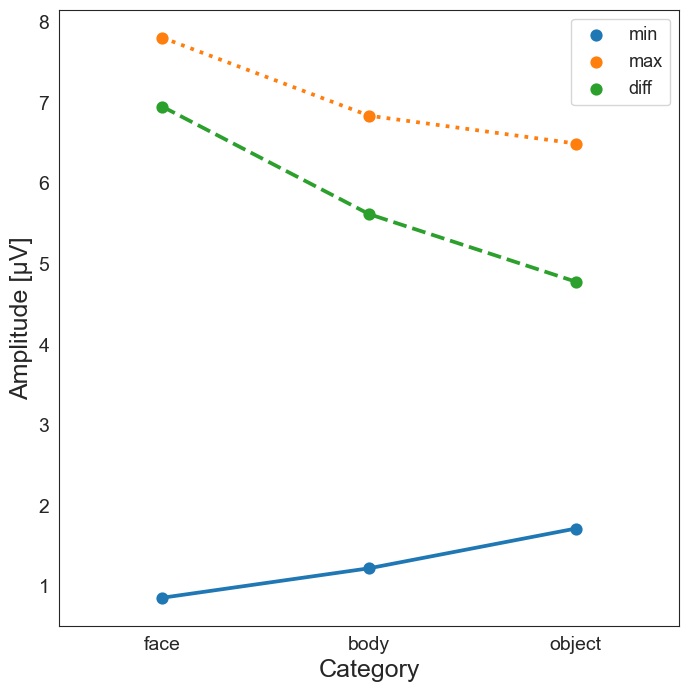

In [444]:
fig, ax = plt.subplots(figsize=(8,8))
sns.pointplot(data=df_means2, x='key',y='value', order=['face','body','object'], hue='variable',linestyles=['-', ':', '--'],ci=None) # TODO: make hue different per category to show in legend
# sns.lineplot(data=df_means2,x='key',y='value', hue='variable')
# ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_ylabel("Amplitude [\u03BCV]", fontsize=18)
ax.set_xlabel("Category", fontsize=18)
plt.legend(fontsize=13, title_fontsize='12')
# ax.set_ylim(0,10)
plt.savefig(data_path + "/images/"+"erps_activations_line_diff"+"."+format, format=format, dpi=1200)

### Means per subject

(0.0, 12.0)

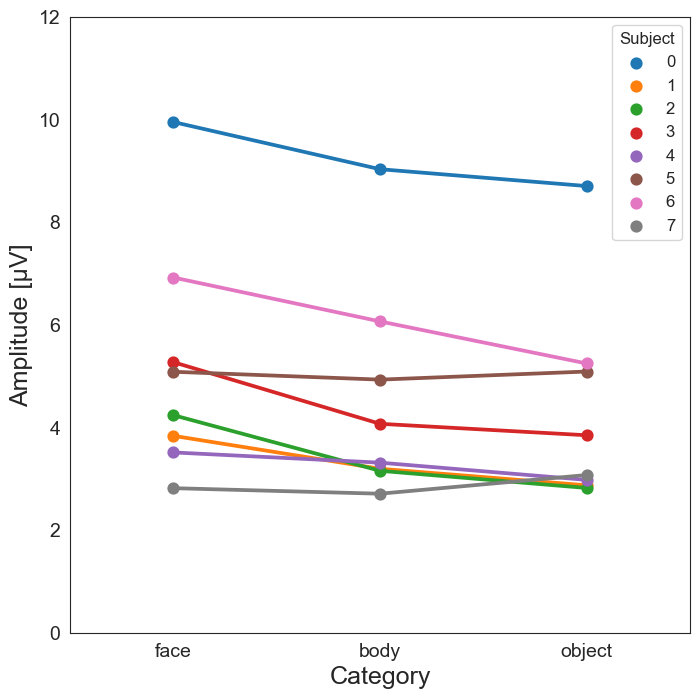

In [634]:
# sns.pointplot(data=df_means2, x= 'variable',y='value', hue='subject', order=['face','body','object']) # By subject by category
fig, ax = plt.subplots(figsize=(8,8))
sns.pointplot(data=df_means2, x='key',y='value', hue='subject',order=['face','body','object'],ci=None) # TODO: make hue different per category to show in legend
# sns.lineplot(data=df_means2,x='key',y='value', hue='variable')
# ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_ylabel("Amplitude [\u03BCV]", fontsize=18)
ax.set_xlabel("Category", fontsize=18)
plt.legend(title="Subject",fontsize=12, title_fontsize='12')
ax.set_ylim(0,12)

In [395]:
df_means = df_min_max.groupby(['key']).mean()
df_means

,min,max,diff
key,,,
body,1.221208,6.836766,5.615558
face,0.855872,7.804643,6.948771
object,1.714381,6.491597,4.777216


In [396]:
df_means = df_min_max.groupby(['key']).median()
df_means

,min,max,diff
key,,,
body,2.379958,5.537165,5.042359
face,0.175412,6.991476,5.350183
object,2.064239,5.189140,4.143893


In [471]:
df_min_max.query('key == "face"').mean()

/var/folders/yy/s3wgmwl10fg_cc7cb_s92snr0000gn/T/ipykernel_59651/1831078098.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_min_max.query('key == "face"').mean()


subject    3.500000
min        0.855872
max        7.804643
diff       6.948771
dtype: float64

In [468]:
df_min_max.query('key == "body"').describe()

,min,max,diff
count,8.000000,8.000000,8.000000
mean,1.221208,6.836766,5.615558
std,2.681199,3.179160,3.480806
min,-3.881315,4.062269,0.995982
25%,-0.565664,4.775523,4.038375
50%,2.379958,5.537165,5.042359
75%,2.945740,7.820810,6.648423
max,3.735118,13.544217,11.304225


In [469]:
df_min_max.query('key == "object"').describe()

,min,max,diff
count,8.000000,8.000000,8.000000
mean,1.714381,6.491597,4.777216
std,2.258026,3.030565,2.638449
min,-2.695131,4.229972,1.550667
25%,0.884934,4.426133,3.025659
50%,2.064239,5.189140,4.143893
75%,3.027443,7.690920,6.139816
max,4.273242,13.051940,8.778697


In [478]:
df_statts = df_min_max.describe()
df_statts

,min,max,diff
count,24.000000,24.000000,24.000000
mean,1.263820,7.044335,5.780515
std,2.829868,3.130173,3.701853
min,-5.477519,4.062269,0.995982
25%,-0.565378,4.700365,3.237197
50%,2.050550,5.937488,4.981686
75%,2.983851,7.877138,6.852787
max,6.478173,14.922929,15.498941


In [481]:
import researchpy as rp
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.anova import AnovaRM
from statsmodels.formula.api import ols


In [503]:
df_cleaned

,body,face,object,subj_time,subject
0,5.915901,6.110841,5.858163,-311.295573,0.0
1,6.088581,6.456994,6.140627,-309.342448,0.0
2,6.139641,6.606117,6.448425,-307.389323,0.0
3,6.593696,6.790761,6.460158,-305.436198,0.0
4,6.589998,7.117500,6.645327,-303.483073,0.0
...,...,...,...,...,...
2859,5.010485,5.210922,4.485417,421.126302,7.0
2860,5.001881,5.355083,4.451282,423.079427,7.0
2861,5.043113,5.256223,4.632553,425.032552,7.0
2862,5.057186,5.056796,4.908361,426.985677,7.0


### Hypothesis:
h0: the average erp responses to faces, objects and bodies is the same across all subjects
h1: the average erp responses to faces, objects and bodies is not the same across all subjects

h0: is rejected for faces and objects and accepted bodies.
h1: is rejected for bodies and accepted faces and objects.


In [512]:
new = ols('subject ~ face + body + object', data=df_cleaned).fit()
an = sm.stats.anova_lm(new, typ=2)
an

,sum_sq,df,F,PR(>F)
face,131.574115,1.0,25.475881,4.760119e-07
body,0.424947,1.0,0.082280,7.742522e-01
object,113.343540,1.0,21.946007,2.935264e-06
Residual,14770.910997,2860.0,NaN,NaN


In [511]:
print(new.summary())

                            OLS Regression Results                            
Dep. Variable:                subject   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     17.11
Date:                Tue, 07 Mar 2023   Prob (F-statistic):           5.19e-11
Time:                        23:33:14   Log-Likelihood:                -6413.0
No. Observations:                2864   AIC:                         1.283e+04
Df Residuals:                    2860   BIC:                         1.286e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5089      0.049     71.623      0.0

In [513]:
df_min_max

,subject,key,min,max,diff
0,0,body,2.239992,13.544217,11.304225
1,0,face,-0.576012,14.922929,15.498941
2,0,object,4.273242,13.051940,8.778697
3,1,body,-0.745509,4.790331,5.535840
4,1,face,-0.561833,5.753467,6.315299
5,1,object,1.141222,4.307212,3.165991
6,2,body,3.735118,4.731100,0.995982
7,2,face,0.912657,6.357432,5.444776
8,2,object,2.679305,4.229972,1.550667
9,3,body,-3.881315,6.104856,9.986170


In [543]:
df_means2

,subject,key,variable,value
0,0,body,min,2.239992
1,0,face,min,-0.576012
2,0,object,min,4.273242
3,1,body,min,-0.745509
4,1,face,min,-0.561833
...,...,...,...,...
67,6,face,diff,3.901594
68,6,object,diff,3.795697
69,7,body,diff,4.567984
70,7,face,diff,5.255591


In [551]:
new2 = ols('value ~ C(variable)', data=df_means2).fit()
an = sm.stats.anova_lm(new2, typ=2)
an

,sum_sq,df,F,PR(>F)
C(variable),443.297087,2.0,21.102786,7.061998e-08
Residual,724.726544,69.0,NaN,NaN


In [552]:
print(new2.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     21.10
Date:                Wed, 08 Mar 2023   Prob (F-statistic):           7.06e-08
Time:                        00:11:03   Log-Likelihood:                -185.29
No. Observations:                  72   AIC:                             376.6
Df Residuals:                      69   BIC:                             383.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.7805      0

In [565]:
# For all statistical tests we assume alpha = 0.05
alpha = 0.05

# TODO: Filter for competitive trials
df_comp = df_means2[df_means2['key'] == 'face']
df_comp
# TODO: Calculate the mean response times per subject per task
df_grouped = df_comp.groupby(['subject', 'variable'])
#
# #
# # # # TODO: Create 2 dataframes, one for the data of the orientation discrimination task,
# # # #       one for the data of the spatial discrimination task
max = df_grouped[df_grouped['variable'] == 'max']
max
# body = df_grouped[df_grouped['key'] == 'body']
# object = df_grouped[df_grouped['task'] == 'object']

KeyError: 'Column not found: False'